# Visualization of Single-bit Quantization of a Gaussian Source

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

In the following we wil explore quantizing a source $X \sim \mathcal{N}(0,1)$ with a single bit per source symbol.
We will use a square error distortion measure $d(x, \hat{x}) = (x-\hat{x})^2$.
The minimum rate $R$ achievable with distortion $D = \mathbb{E}\{d(X,\hat{X})\}$ is given by the rate distortion function
$$
R(D) = \begin{cases}
\frac12 \log_2\!\!\left(\frac{\sigma^2}{D}\right), & 0 \leq D \leq \sigma^2, \\
0, & D > \sigma^2.
\end{cases}
$$
As we will quantize with one bit per symbol, we have fixed $R(D) = 1$.
Solving for $D$, we find that the minimum achievable distortion is
$$
D = \sigma^2 \cdot 2^{-2R} = 1 \cdot 2^{-2} = \frac14.
$$

In [2]:
def d(x, x_hat):
    """ Square error distortion measure """
    return (x - x_hat)**2

R = 1

D_minimum = 1/4

We start by quantizing the $N$ independent random variables (RVs) $X^N \sim \text{iid.}\ \mathcal{N}(0,1)$ individually with one bit. In this case, the optimumal quantization levels are
$$
\hat{x}_{1,2} = \pm \sigma \sqrt{\frac{2}{\pi}}.
$$

Avg. distortion: 0.3633
Theory: D(R = 1) = 0.25


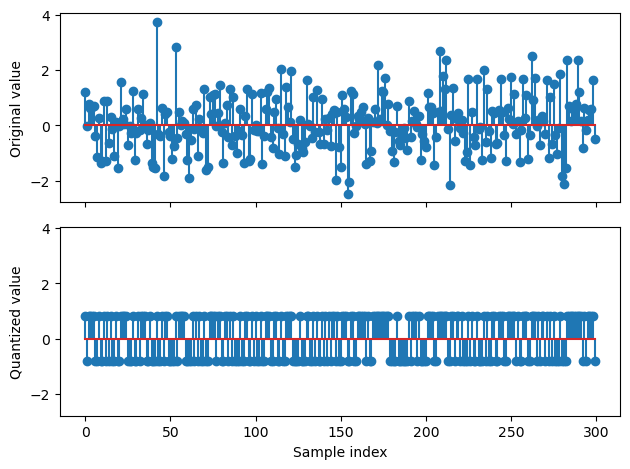

In [3]:
def quantize_sigle_RV(x, sigma = 1):
    optimum_level = sigma * np.sqrt(2/np.pi)
    quantized = np.zeros_like(x)
    quantized[x >= 0] = optimum_level
    quantized[x < 0] = -optimum_level
    return quantized


x = np.random.randn(10000000)
quantized = quantize_sigle_RV(x)

distortion_n1 = np.mean(d(x, quantized))

print(f'Avg. distortion: {distortion_n1:.4f}')
print(f'Theory: D(R = 1) = {D_minimum}')

# Smaller data set for plotting
x = np.random.randn(300)
quantized = quantize_sigle_RV(x)

ax1 = plt.subplot(211)
plt.stem(x)
plt.ylabel('Original value')
plt.tick_params('x', labelbottom=False)
plt.subplot(212, sharex=ax1, sharey=ax1)
plt.stem(quantized)
plt.xlabel('Sample index')
plt.ylabel('Quantized value')

plt.tight_layout()

We notice a sizable gap between the theoretically achievable minimum distortion and the distortion we observe above. How can we close this gap?

The rate-distortion theorem presented in the lecture claims that the minimum distortion $D = \frac14$ is (asymptotically) achievable if batches of $n$ RVs $X^n \sim \text{iid. } \mathcal{N}(0,1)$ are quantized together and $n \to \infty$.
Thus, we increase the number of RVs that are quantized together to reduce the gap.
If we jointly quantize $n$ RVs with $n$ bits, we retain the rate $R=1$.

**Problem:**
Finding a good quantization codebook for large $n$ quickly becomes complex.
Somewhat heuristically¹ we use a random codebook where each entry is randomly drawn according to $\mathcal{N}(0, 1-D)$.
We will see that this random codebook produces good results for sufficiently large $n$.


<small>¹ Our choice is inspired by the achievability proof of the rate-distortion function for a Gaussian source in Thomas M. Cover and Joy A. Thomas, 2006, "Elements of Information Theory".</small>

Avg. distortion n = 1: 0.3633
Avg. distortion n = 10: 0.3385
Theory: D(R = 1) = 0.25


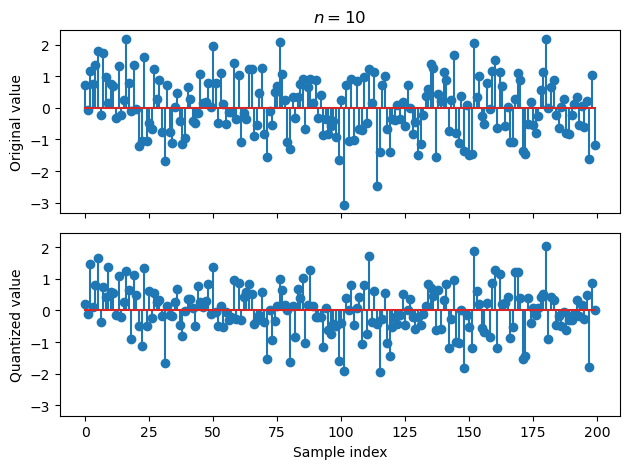

In [4]:
def quantize_many_RV(x, sigma = 1):
    num_samples, n = x.shape

    codebook = np.random.normal(0, np.sqrt(sigma**2 - 0.25), (2**n, n))

    closest_idx = []
    num_chuncks = (num_samples // 100) + 1 # split into chuncks to save memory
    for chunck in np.array_split(x, num_chuncks):
        distances = distance.cdist(chunck, codebook, 'euclidean')
        closest_idx += list(np.argmin(distances, axis=-1))

    return codebook[closest_idx]


n = 10
x = np.random.randn(1000000, n)
quantized = quantize_many_RV(x)

print(f'Avg. distortion n = 1: {distortion_n1:.4f}')
print(f'Avg. distortion n = {n}: {np.mean(d(x, quantized)):.4f}')
print(f'Theory: D(R = 1) = {D_minimum}')

# Smaller data set for plotting
x = np.random.randn(200//n, n)
quantized = quantize_many_RV(x)

ax1 = plt.subplot(211)
plt.title(f'$n = {n}$')
plt.stem(x.flatten())
plt.ylabel('Original value')
plt.tick_params('x', labelbottom=False)
plt.subplot(212, sharex=ax1, sharey=ax1)
plt.stem(quantized.flatten())
plt.xlabel('Sample index')
plt.ylabel('Quantized value')

plt.tight_layout()

Further increasing $n$ reduces the distortion even further, but becomes computationally more costly.

---
**WARNING:** Executing the cell below requires $\approx 10\,\text{GB}$ RAM and can freeze or crash a PC with insufficient specs.

---

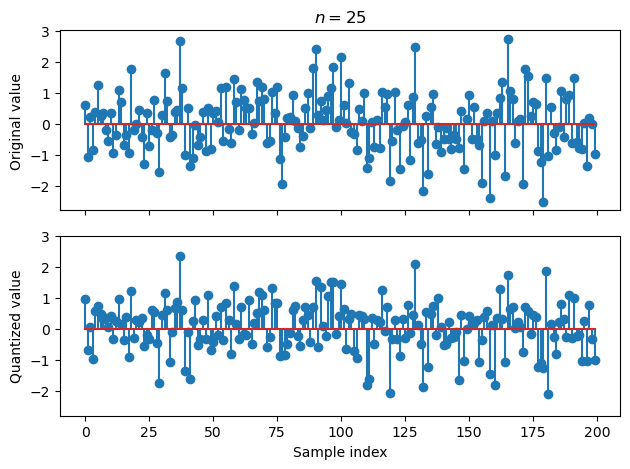

In [5]:
n = 25 # reduce n to use less RAM

# Smaller data set for plotting
x = np.random.randn(200//n, n)
quantized = quantize_many_RV(x)

ax1 = plt.subplot(211)
plt.title(f'$n = {n}$')
plt.stem(x.flatten())
plt.ylabel('Original value')
plt.tick_params('x', labelbottom=False)
plt.subplot(212, sharex=ax1, sharey=ax1)
plt.stem(quantized.flatten())
plt.xlabel('Sample index')
plt.ylabel('Quantized value')

plt.tight_layout()

Finally, lets get an overview of how the achieved distortion reduces with increasing $n$.

Finished calculation for: 10 13 15 16 17 18 19 20 

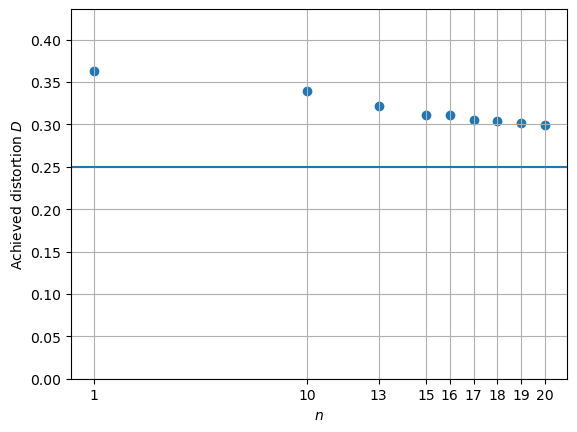

In [6]:
n_range = np.array([1, 10, 13, 15, 16, 17, 18, 19, 20])
D_values = [distortion_n1]
print('Finished calculation for:', end=' ')
for n in n_range[1:]:
    x = np.random.randn(10000, n)
    quantized = quantize_many_RV(x)
    D_values.append(np.mean(d(x, quantized)))
    print(n, end=' ', flush=True)

plt.scatter(n_range, D_values)
plt.gca().axhline(D_minimum)
plt.ylim(0, 1.2 * max(D_values))
plt.xticks(n_range)
plt.xlabel('$n$')
plt.ylabel('Achieved distortion $D$')
plt.grid()

Looking at the plot above we can believe, that we will reach the theoretical limit with $n\to\infty$.
(However, as our approach in this notebook is rather heuristic, we can give no guarantees that we will indeed reach the theoretical limit with the construction used here.)